# Introduction
------------

## Extremely Brief Probabilistic Programming Background
Probabilistic programming languages like `Pyro`, `Turing.jl`, `Gen.jl`, `Stan`, etc. (partially) automate the difficult task of probabilistic modeling and inference.

TLDR: Bayes Theorem is very flexible and powerful, but hard to work with!

These technologies build on techniques in programming languages theory, Bayesian statistics, and probabilistic machine learning to provide efficient model-agnostic approximate solutions to hard probabilsitic inference problems.

## General ASKEM Goal 1: 
Represent continuous-time dynamical systems models with uncertainty as probabilistic programs in a probabilistic programming language.

## General ASKEM Goal 2:
Represent ASKEM questions in terms of primitive query operations that PPLs (partially) automate for any probabilistic program. 

In `Pyro` and `CausalPyro`, the probabilistic programming languages we're using and developing: this includes operations like `sample`, `condition`, `intervene`, etc.

## Ensemble Challenge Goal:
Demonstrate how probabilsitic programming lets us think about probabilsitic models the way we think about software.

First, we'll demonstrate how we can build probabilistic ensemble models compositionally from probabilsitic ODE models, with very few lines of code, and without losing any probabilsitic modeling functionality.

Second, we'll show how to use our ASKEM-specific abstractions for building ensemble models in a no-code workflow. Using these abstractions, we'll make example forecasts based on historical data.

-----------

# A Brief Tour of Ensemble Modeling in PyCIEMSS

```python

class DynamicalSystem(pyro.nn.module):
    
    ...

    def forward(self, *args, **kwargs) -> Solution:
        '''
        Joint distribution over model parameters, trajectories, and noisy observations.
        '''
        # Setup the anything the dynamical system needs before solving.
        self.setup_before_solve()

        # Sample parameters from the prior
        self.param_prior()

        # "Solve" the Dynamical System
        solution = self.get_solution(*args, **kwargs)        

        # Add the observation likelihoods for probabilistic inference (if applicable)
        self.add_observation_likelihoods(solution)

        return self.log_solution(solution) 
```

```python

class ODESystem(DynamicalSystem):
    
    ...

    def param_prior(self):
        # Sample all of the parameters from the prior and store them as attributes of the ODESystem.
        ...
    
    def get_solution(*args, **kwargs):
        # Run an off-the-shelf ODE solver, using the parameters generated from the call to self.param_prior()
        # Make sure to evaluate at all points the user wants logged, and at all observations.
        ...
        local_solution = torchdiffeq.odeint(self.deriv, initial_state, local_tspan)
        ...
    
```

```python
class EnsembleSystem(DynamicalSystem):

        def __init__(self, 
                     models: List[DynamicalSystem], 
                     dirichlet_alpha: torch.tensor,
                     solution_mappings: Callable) -> None:

        self.models = models
        self.dirichlet_alpha = dirichlet_alpha
        self.solution_mappings = solution_mappings

    ...

    def param_prior(self):
        # The prior distribution over parameters in an ensemble is just the prior distribution over each constituent model's parameters.
        for i, model in enumerate(self.models):
            with scope(prefix=f'model_{i}'):
                model.param_prior()
    
    def get_solution(self, *args, **kwargs):
        
        # Sample model weights from a Dirichlet distribution
        model_weights = pyro.sample('model_weights', pyro.distributions.Dirichlet(self.dirichlet_alpha))

        # Solve the Dynamical System for each model in self.models, mapping outputs to the shared state representation.
        solutions = [mapping(model.get_solution(*args, **kwargs)) for model, mapping in zip(self.models, self.solution_mappings)]

        # Combine the ensemble solutions, scaled by `model_weights`.
        solution = {k: sum([model_weights[i] * v[k] for i, v in enumerate(solutions)]) for k in solutions[0].keys()}

        return solution
```


---

### Limitations

1. Fixed parameters for all time
2. Fixed mixture weights for all time

### Possible Future Developments

1. Translate ODE models to SDE models with time-varying stochastic parameters. (Be careful for reasons Chris R mentioned)
2. Allows mixture to weights to smoothly vary (with uncertainty) over time. 
    - Hidden markov model with local transitions over mixture weights
    - Gaussian process prior over time-varying dirichlet weights

# A Brief Tour of ASKEM-specific interfaces

Here we show how PyCIEMSS can be used in a no-code (or low-code) modeling workflow

In [55]:
# First, let's load the dependencies and set up the notebook environment.
import os

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyciemss.PetriNetODE.interfaces import load_petri_model
from pyciemss.Ensemble.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize
import vega
import json

## Load Data

In [56]:
# works with main 
# Load the data as a torch tensor.
DATA_PATH = "../../../notebook/april_ensemble/covid_data/"
data_filename = "US_case_hospital_death.csv"
data_filename = os.path.join(DATA_PATH, data_filename)

data = pd.read_csv(data_filename)

# Clip off the first 2 months of data
data_total_population = 331893745
train_start_date = "2021-12-01"
test_start_date = "2022-03-01"
test_end_date = "2022-04-01"


In [57]:
def get_train_test_data(data: pd.DataFrame, train_start_date: str, test_start_date: str, test_end_date: str) -> pd.DataFrame:
    train_df = data[(data['date'] >= train_start_date) & (data['date'] < test_start_date)]
    train_data = [0] * train_df.shape[0]
    start_time = train_df.index[0]

    train_cases = np.array(train_df["case_census"].astype("float")) / data_total_population
    train_timepoints = np.array(train_df.index.astype("float"))

    test_df = data[(data['date'] >= test_start_date) & (data['date'] < test_end_date)]
    test_cases = np.array(test_df["case_census"].astype("float")) / data_total_population
    test_timepoints = np.array(test_df.index.astype("float"))

    for time, row in train_df.iterrows():
        row_dict = {}
        row_dict["Cases"] = row["case_census"] / data_total_population
        row_dict["Dead"] = row["cumulative_deaths"] / data_total_population
        if row["hospital_census"] > 0:
            row_dict["Hospitalizations"] = row["hospital_census"] / data_total_population

        index = time - start_time
        train_data[index] = (float(time), row_dict)
    
    all_timepoints = np.concatenate((train_timepoints, test_timepoints))

    return train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints

In [58]:
train_data, train_cases, train_timepoints, test_cases, test_timepoints, all_timepoints = get_train_test_data(data, train_start_date, test_start_date, test_end_date)

## Setup Models

### Model 1

In [59]:
MIRA_PATH = "../../../test/models/april_ensemble_demo/"

filename1 = "BIOMD0000000955_template_model.json"
filename1 = os.path.join(MIRA_PATH, filename1)
model1 = load_petri_model(filename1, add_uncertainty=True)

model1

ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	gamma = Uniform(low: 0.41040000319480896, high: 0.5016000270843506),
	delta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	alpha = Uniform(low: 0.5130000114440918, high: 0.6269999742507935),
	epsilon = Uniform(low: 0.15389999747276306, high: 0.18809999525547028),
	zeta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	XXlambdaXX = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	eta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	rho = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	theta = Uniform(low: 0.33390000462532043, high: 0.4081000089645386),
	kappa = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	mu = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	nu = Uniform(low: 0.024299999698996544, high: 0.02969999983906746),
	xi = Uniform(low: 0.015300000086426735, high: 

In [60]:
def create_start_state1(data, start_date):
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}
    returned_state["Extinct"] = start_state['cumulative_deaths']
    
    if np.isnan(start_state['hospital_census']):
        returned_state["Threatened"] = start_state['case_census'] / 100
    else:
        returned_state["Threatened"] = start_state['hospital_census']

    returned_state["Diagnosed"] = start_state['case_census'] / 2
    returned_state["Recognized"] = start_state['case_census'] / 2
    returned_state['Infected'] = start_state['case_census'] * 5
    returned_state['Ailing'] = returned_state["Threatened"] * 50

    returned_state['Healed'] = start_state['cumulative_deaths'] * 50
    returned_state['Susceptible'] =  data_total_population - sum(returned_state.values())
    assert(returned_state['Susceptible'] > 0)
    return {k:v/data_total_population for k, v in returned_state.items()}

In [61]:
test_dates = pd.date_range(start=train_start_date, end=test_end_date, freq="1D")
test_dates = [date.strftime("%Y-%m-%d") for date in test_dates[1:-1]]

In [62]:
# Check all dates to make sure no initial values are negative
[create_start_state1(data, date) for date in test_dates]

start_state1 = create_start_state1(data, train_start_date)
start_state1

{'Extinct': 0.002354530664625813,
 'Threatened': 0.00012599815642804597,
 'Diagnosed': 0.0014301113146919957,
 'Recognized': 0.0014301113146919957,
 'Infected': 0.014301113146919958,
 'Ailing': 0.006299907821402298,
 'Healed': 0.11772653323129063,
 'Susceptible': 0.8563316943499493}

In [63]:
# Taken from "observables" in JSON file
def solution_mapping1(model1_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Cases"] = model1_solution["Diagnosed"] + model1_solution["Recognized"]
    mapped_dict["Hospitalizations"] = model1_solution["Threatened"]
    mapped_dict["Dead"] = model1_solution["Extinct"]
    return mapped_dict

## NOTE - This mapping from MIRA uses the same state variables multiple times. This violates the implicit mass balance assumption of this ensemble.

We changed the above mapping to ensure that each state variable was used only once.

### Model 2

In [64]:
filename2 = "BIOMD0000000960_template_model.json"
filename2 = os.path.join(MIRA_PATH, filename2)
model2 = load_petri_model(filename2, add_uncertainty=True)

# TODO: put this into the interfaces
mira_start_state2 = {k[0]: v.data['initial_value'] for k, v in model2.G.variables.items()}

model2

/Users/oost464/Library/CloudStorage/OneDrive-PNNL/Desktop/projects/pyciemss/src/pyciemss/PetriNetODE/base.py:467: UserWarning: Parameter delta_A has value 0.0 <= 0.0 and will be set to Uniform(0, 0.1)
  warnings.warn(warnings_string)
/Users/oost464/Library/CloudStorage/OneDrive-PNNL/Desktop/projects/pyciemss/src/pyciemss/PetriNetODE/base.py:467: UserWarning: Parameter mira_param_9 has value 0.0 <= 0.0 and will be set to Uniform(0, 0.1)
  warnings.warn(warnings_string)


ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 8.308957966107755e-10, high: 1.015539319304537e-09),
	mira_param_1 = Uniform(low: 3.398363812578964e-09, high: 4.153555721586599e-09),
	mira_param_2 = Uniform(low: 7.070923291330189e-10, high: 8.642239701650567e-10),
	mira_param_3 = Uniform(low: 0.02098800055682659, high: 0.025652000680565834),
	mira_param_4 = Uniform(low: 0.37501201033592224, high: 0.45834800601005554),
	mira_param_5 = Uniform(low: 0.0494999997317791, high: 0.060499999672174454),
	mira_param_6 = Uniform(low: 0.266400009393692, high: 0.3255999982357025),
	mira_param_7 = Uniform(low: 0.02070000022649765, high: 0.025299999862909317),
	mira_param_8 = Uniform(low: 1.4759999513626099, high: 1.8040000200271606),
	mira_param_9 = Uniform(low: 0.0, high: 0.10000000149011612),
	mira_param_10 = Uniform(low: 0.0002610000083222985, high: 0.00031900001340545714),
	mira_param_11 = Uniform(low: 0.016200000420212746, high: 0.01979999989271164),
	pseudocount = 1.0
)

In [65]:
model2_total_population = sum(mira_start_state2.values())

def solution_mapping2(model2_solution: dict) -> dict:
    mapped_dict = {}
    mapped_dict["Cases"] = model2_solution["Infectious"] / model2_total_population
    mapped_dict["Hospitalizations"] = model2_solution["Hospitalized"] / model2_total_population
    mapped_dict["Dead"] = model2_solution["Deceased"] / model2_total_population
    return mapped_dict

In [66]:
def create_start_state2(data, start_date):
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}
    returned_state["Deceased"] = start_state['cumulative_deaths']
    
    if np.isnan(start_state['hospital_census']):
        returned_state["Hospitalized"] = start_state['case_census'] / 100
    else:
        returned_state["Hospitalized"] = start_state['hospital_census']
    
    returned_state["Infectious"] = start_state['case_census']

    returned_state['Exposed'] = start_state['case_census'] * 10
    returned_state['Asymptomatic'] = start_state['case_census'] * 5

    returned_state['Recovered'] = start_state['cumulative_deaths'] * 10

    returned_state['Susceptible'] =  data_total_population - sum(returned_state.values())
    assert(returned_state['Susceptible'] > 0)
    return {k:v*(model2_total_population/data_total_population) for k, v in returned_state.items()}

In [67]:
[create_start_state2(data, date) for date in test_dates]
start_state2 = create_start_state2(data, train_start_date)
start_state2

{'Deceased': 23402.923467906872,
 'Hospitalized': 1252.362203764943,
 'Infectious': 28429.262910995807,
 'Exposed': 284292.62910995807,
 'Asymptomatic': 142146.31455497904,
 'Recovered': 234029.23467906873,
 'Susceptible': 9225975.273073327}

### Model 3

In [68]:
filename3 = "BIOMD0000000983_template_model.json"
filename3 = os.path.join(MIRA_PATH, filename3)
model3 = load_petri_model(filename3, add_uncertainty=True)

# TODO: put this into the interfaces
mira_start_state3 = {k[0]: v.data['initial_value'] for k, v in model3.G.variables.items()}
mira_start_state3['Deceased'] = 0.0

model3

ScaledBetaNoisePetriNetODESystem(
	mira_param_0 = Uniform(low: 7.614000097078133e-09, high: 9.306000414710525e-09),
	mira_param_1 = Uniform(low: 1.5228000194156266e-08, high: 1.861200082942105e-08),
	mira_param_2 = Uniform(low: 1.9035000242695332e-09, high: 2.326500103677631e-09),
	mira_param_3 = Uniform(low: 3.8070000485390665e-09, high: 4.653000207355262e-09),
	mira_param_4 = Uniform(low: 0.019285714253783226, high: 0.023571427911520004),
	mira_param_5 = Uniform(low: 0.035999998450279236, high: 0.04399999976158142),
	mira_param_6 = Uniform(low: 0.14399999380111694, high: 0.17599999904632568),
	mira_param_7 = Uniform(low: 0.09000000357627869, high: 0.10999999940395355),
	mira_param_8 = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	mira_param_9 = Uniform(low: 0.044999998062849045, high: 0.054999999701976776),
	mira_param_10 = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	pseudocount = 1.0
)

In [69]:
mira_start_state3

{'Infected_reported': 12.0,
 'Exposed': 112.0,
 'Susceptible_unconfined': 66990000.0,
 'Infected_unreported': 50.0,
 'Quarantined': 36.0,
 'Recovered': 0.0,
 'Deceased': 0.0}

In [70]:
model3_total_population = sum(mira_start_state3.values())
h = 0.01

def solution_mapping3(model3_solution: dict) -> dict:
    mapped_dict = {}
    # Ideally we would make better use of this distinction between "reported" and "unreported".
    # However, as other models don't include this distinction, we must instead sum them together to make solution outputs comparable.
    mapped_dict["Cases"] = model3_solution["Infected_reported"] / model3_total_population
    mapped_dict["Hospitalizations"] = (model3_solution["Infected_unreported"] * h) / model3_total_population
    mapped_dict["Dead"] = (model3_solution["Deceased"]) / model3_total_population
    return mapped_dict


In [71]:
#model2_total_population

In [72]:
def create_start_state3(data, start_date):
    start_state = data.set_index('date').loc[start_date].to_dict()

    returned_state = {}

    if np.isnan(start_state['hospital_census']):
        returned_state["Infected_unreported"] = start_state['case_census'] / (100 * h)
    else:
        returned_state["Infected_unreported"] = start_state['hospital_census']/h

    returned_state["Infected_reported"] = start_state['case_census']
    returned_state["Deceased"] = start_state['cumulative_deaths']
    returned_state['Exposed'] = start_state['case_census'] * 10
    returned_state['Recovered'] = start_state['cumulative_deaths'] * 5
    returned_state['Quarantined'] = returned_state["Infected_reported"] * 0.5

    returned_state['Susceptible_unconfined'] =  data_total_population - sum(returned_state.values())
    assert(returned_state['Susceptible_unconfined'] > 0)
    return {k:v*(model3_total_population/data_total_population) for k, v in returned_state.items()}

In [73]:
[create_start_state3(data, date) for date in test_dates]
start_state3 = create_start_state3(data, train_start_date)
start_state3

{'Infected_unreported': 844064.2958727649,
 'Infected_reported': 191606.91458918576,
 'Deceased': 157730.50367472277,
 'Exposed': 1916069.1458918576,
 'Recovered': 788652.5183736138,
 'Quarantined': 95803.45729459288,
 'Susceptible_unconfined': 62996283.16430326}

In [74]:
print(f"Model 1 mapped start state is {solution_mapping1(start_state1)}")
print(f"Model 2 mapped start state is {solution_mapping2(start_state2)}")
print(f"Model 3 mapped start state is {solution_mapping3(start_state3)}")

Model 1 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00012599815642804597, 'Dead': 0.002354530664625813}
Model 2 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00012599815642804597, 'Dead': 0.0023545306646258124}
Model 3 mapped start state is {'Cases': 0.0028602226293839915, 'Hospitalizations': 0.00012599815642804597, 'Dead': 0.002354530664625813}


In [75]:
print(f"Model 2 total population is {model2_total_population}")
print(f"Model 3 total population is {model3_total_population}")
print("These values are not equal, initiate reachback to TA1 and TA2!")

Model 2 total population is 9939528.0
Model 3 total population is 66990210.0
These values are not equal, initiate reachback to TA1 and TA2!


In [76]:
# Assert that all of the variables in the solution mappings are the same.
assert(set(solution_mapping1(start_state1).keys()) 
       == set(solution_mapping2(start_state2).keys())
       == set(solution_mapping3(start_state3).keys()))

## Setup some plotting utilities

In [77]:
def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time since start of pandemic (days)')
    ax.set_ylabel('Cases (Prop. of Population)')
    ax.set_yscale('log')
    return ax

def plot_trajectory(prediction, tspan, ax=None, alpha=0.2, color="black", **kwargs):
    tspan = torch.as_tensor(tspan)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    I = prediction["Cases_sol"].detach().numpy().squeeze()
    ax.plot(tspan, I, alpha=0.5, lw=2, color=color, **kwargs)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_predictive(prediction, tspan, ax=None, title=None, alpha=0.2, color="black", **kwargs):
    tspan = torch.as_tensor(tspan)
    indeces = torch.ones_like(tspan).bool()
    
    I_low = torch.quantile(prediction["Cases_sol"], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction["Cases_sol"], 0.95, dim=0).detach().numpy()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if title:
        ax.set_title(title)

    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_observations(data, tspan,  ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, ):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data, color, alpha=alpha, lw=lw, marker=marker, label=label)
    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)
    
    return ax

from pyro.distributions import Dirichlet
import matplotlib.tri as tri

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)

# For each corner of the triangle, the pair of other corners
pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
# The area of the triangle formed by point xy and another pair or points
tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))

def xy2bc(xy, tol=1.e-4):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    coords = np.array([tri_area(xy, p) for p in pairs]) / AREA
    return np.clip(coords, tol, 1.0 - tol)

# Adapted from https://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
def plot_weights(samples, ax=None, title=None, concentration=20, nlevels=200, subdiv=7, **kwargs):
    import math
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)

    # convert to coordinates with 3, rather than to points of reference for Direichlet input
    points = torch.tensor(np.array([(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]))
    points /= torch.sum(points, dim=1, keepdim=True)

    alpha = samples * concentration
    vals = torch.stack([torch.exp(Dirichlet(alpha).log_prob(points[i,:])) for i in range(points.shape[0])])
    vals /= torch.max(vals, dim=0, keepdim=True)[0]
    vals = torch.sum(vals, dim=1)
    vals /= torch.sum(vals)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    if title:
        ax.set_title(title)

    coordinates_dict = {}

    # skip every line as alternates half of each lines
    y_num =0
    not_use_trimesh_y = []
    for y in np.unique(trimesh.y):
        y_num += 1
        if y_num%2 == 0:
            not_use_trimesh_y.append(y)

    df_coord = pd.DataFrame({'x': trimesh.x, 'y': trimesh.y, 'z': vals.tolist()})
    not_use_trimesh_x = list(np.unique(df_coord[df_coord.y==not_use_trimesh_y[0]]['x'].tolist()))

    # save all existing coordinates
    for x, y, z in zip(trimesh.x, trimesh.y, vals):
        coordinates_dict[(x,y)] = z.item()
    
    # fill in missing part of square grid
    for x in np.unique(trimesh.x):
        for y in np.unique(trimesh.y):
                if (x,y) not in coordinates_dict.keys():
                    coordinates_dict[x,y] = 0
    
    # convert to dataframe and sort with y first in descending order
    df = pd.DataFrame(coordinates_dict.items(), columns=['x,y', 'val'])
    df[['x', 'y']] = pd.DataFrame(df['x,y'].tolist(), index=df.index)
    df = df.sort_values(['y', 'x'], ascending = [False, True])

    # remove the alternative values, (every other y and all the values associated with that y)
    df_use = df[(~df.x.isin(not_use_trimesh_x)) & (~df.y.isin(not_use_trimesh_y))]

    json_dict ={}
    json_dict['width'] = len(np.unique(df_use.x))
    json_dict['height'] = len(np.unique(df_use.y))
    json_dict['values'] = df_use['val'].tolist()
    
    mappable = ax.tricontourf(trimesh, vals, nlevels, cmap='jet', **kwargs)
    ax.axis('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.75**0.5)
    ax.axis('off')

    # label vertices "Model 1", "Model 2", and "Model 3"
    ax.text(-0.05, -0.08, 'Model 1', fontsize=14, ha='left')
    ax.text(1.05, -0.08, 'Model 2', fontsize=14, ha='right')
    ax.text(0.5,  0.75**0.5+0.03, 'Model 3', fontsize=14, ha='center')
    # add a colorbar with no numbers
    plt.colorbar(mappable, ticks=[], pad=0.1, ax=ax)
    return json.dumps(json_dict)

## Prior samples from each individual model

TypeError: 'Predictive' object is not subscriptable

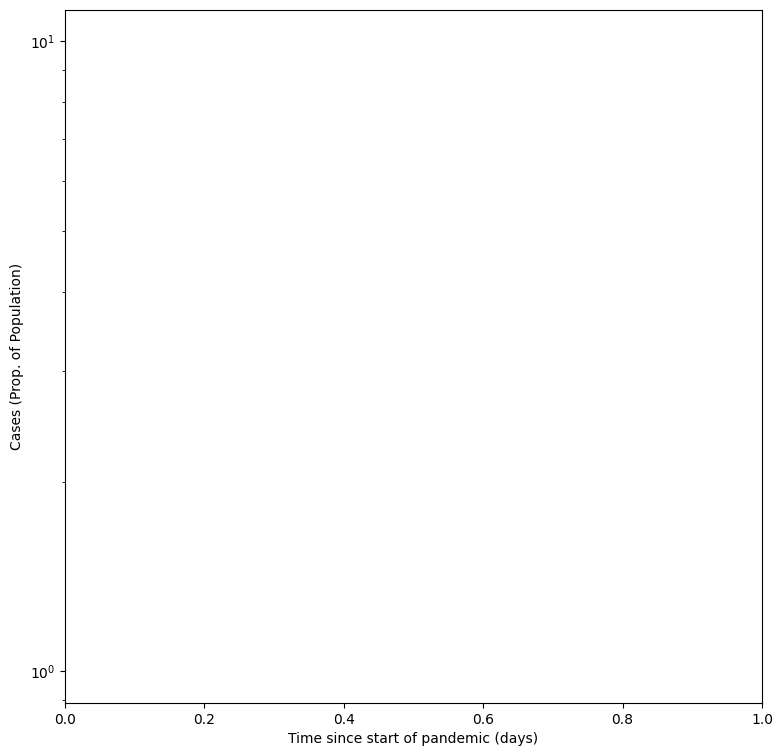

In [78]:
# TODO: change this to be larger
num_samples = 3
# num_samples = 2

start_time = train_timepoints[0] - 1e-5

# Wrapping model1 in a single "ensemble" model automatically applies the solution mapping functions, making these three models easier to compare.
ensemble1 = setup_model([model1], weights=[1.0], start_time=start_time, start_states=[start_state1], solution_mappings=[solution_mapping1])
ensemble1_prior_forecasts = sample(ensemble1, all_timepoints, num_samples)

ensemble2 = setup_model([model2], weights=[1.0], start_time=start_time, start_states=[start_state2], solution_mappings=[solution_mapping2])
ensemble2_prior_forecasts = sample(ensemble2, all_timepoints, num_samples)

ensemble3 = setup_model([model3], weights=[1.0], start_time=start_time, start_states=[start_state3], solution_mappings=[solution_mapping3])
ensemble3_prior_forecasts = sample(ensemble3, all_timepoints, num_samples)

plotting_cases = np.array(data["case_census"][all_timepoints].astype("float")) / data_total_population

# Plot trajectories from the prior.
ax = plot_predictive(ensemble1_prior_forecasts, all_timepoints, title="Prior Forecasts - Individual Models", ax=setup_ax(), color="blue", label="Model 1 Prior Forecasts")
ax = plot_predictive(ensemble2_prior_forecasts, all_timepoints, ax=ax, color="red", label="Model 2 Prior Forecasts")
ax = plot_predictive(ensemble3_prior_forecasts, all_timepoints, ax=ax, color="green", label="Model 3 Prior Forecasts")
ax = plot_observations(plotting_cases, all_timepoints, ax=ax, color="black", label="Reported Cases")

In [ ]:
ensemble2_prior_forecasts

{'model_0/mira_param_0': tensor([9.4595e-10, 9.6313e-10, 9.2174e-10]),
 'model_0/mira_param_1': tensor([3.6058e-09, 4.0417e-09, 3.9840e-09]),
 'model_0/mira_param_2': tensor([7.1523e-10, 8.1962e-10, 7.8403e-10]),
 'model_0/mira_param_3': tensor([0.0210, 0.0227, 0.0246]),
 'model_0/mira_param_4': tensor([0.4123, 0.4209, 0.3838]),
 'model_0/mira_param_5': tensor([0.0592, 0.0585, 0.0547]),
 'model_0/mira_param_6': tensor([0.2967, 0.3165, 0.2965]),
 'model_0/mira_param_7': tensor([0.0237, 0.0246, 0.0238]),
 'model_0/mira_param_8': tensor([1.6718, 1.6093, 1.5633]),
 'model_0/mira_param_9': tensor([0.0680, 0.0958, 0.0224]),
 'model_0/mira_param_10': tensor([0.0003, 0.0003, 0.0003]),
 'model_0/mira_param_11': tensor([0.0178, 0.0169, 0.0181]),
 'model_weights': tensor([[1.0000],
         [1.0000],
         [1.0000]]),
 'Cases_sol': tensor([[2.8602e-03, 2.3567e-03, 1.8716e-03, 1.4486e-03, 1.1001e-03, 8.2327e-04,
          6.0906e-04, 4.4640e-04, 3.2466e-04, 2.3461e-04, 1.6860e-04, 1.2060e-04,
 

In [ ]:
len(ensemble3_prior_forecasts['Cases_sol'][0])
ensemble3_prior_forecasts.keys()
# created with case_sol

dict_keys(['model_0/mira_param_0', 'model_0/mira_param_1', 'model_0/mira_param_2', 'model_0/mira_param_3', 'model_0/mira_param_4', 'model_0/mira_param_5', 'model_0/mira_param_6', 'model_0/mira_param_7', 'model_0/mira_param_8', 'model_0/mira_param_9', 'model_0/mira_param_10', 'model_weights', 'Cases_sol', 'Hospitalizations_sol', 'Dead_sol'])

## NOTE: The MIRA models did not contain enough information to align the data with the start state. We constructed somewhat handwavy mappings manually based on data.

## Setup the full ensemble of all three models

In [ ]:
# Setup the Ensemble

models = [model1, model2, model3]
weights = [1/3, 1/3, 1/3]

start_states = [start_state1, start_state2, start_state3]
solution_mappings = [solution_mapping1, solution_mapping2, solution_mapping3]

ensemble_total_population = 1.0
dirichlet_concentration = 1.0
noise_pseudocount = 100.0

ensemble = setup_model(models, 
                       weights, 
                       solution_mappings, 
                       start_time, 
                       start_states, 
                       ensemble_total_population, 
                       dirichlet_concentration=dirichlet_concentration,
                       noise_pseudocount=noise_pseudocount)
ensemble

Ensemble of 3 models. 

 	Dirichlet Alpha: tensor([0.3333, 0.3333, 0.3333]). 

 	Models: [ScaledBetaNoisePetriNetODESystem(
	beta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	gamma = Uniform(low: 0.41040000319480896, high: 0.5016000270843506),
	delta = Uniform(low: 0.00989999994635582, high: 0.01209999993443489),
	alpha = Uniform(low: 0.5130000114440918, high: 0.6269999742507935),
	epsilon = Uniform(low: 0.15389999747276306, high: 0.18809999525547028),
	zeta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	XXlambdaXX = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	eta = Uniform(low: 0.11249999701976776, high: 0.13750000298023224),
	rho = Uniform(low: 0.03060000017285347, high: 0.03739999979734421),
	theta = Uniform(low: 0.33390000462532043, high: 0.4081000089645386),
	kappa = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	mu = Uniform(low: 0.015300000086426735, high: 0.018699999898672104),
	nu = Uniform(low: 0.02429

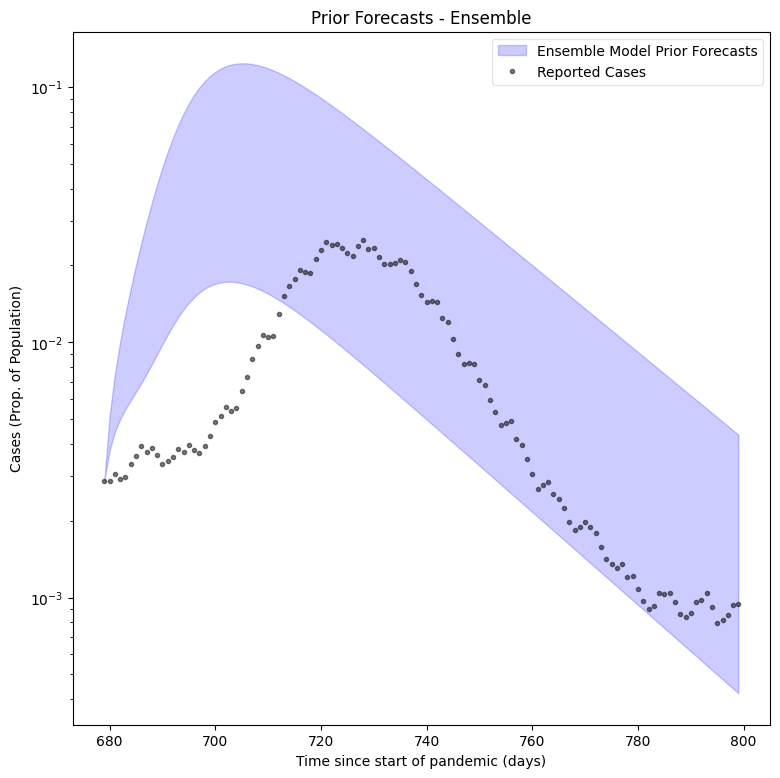

In [ ]:
# Sample from the Ensemble
ensemble_prior_forecasts = sample(ensemble, all_timepoints, num_samples)
ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), title="Prior Forecasts - Ensemble", color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_observations(plotting_cases, all_timepoints, ax=ax, color="black", label="Reported Cases")

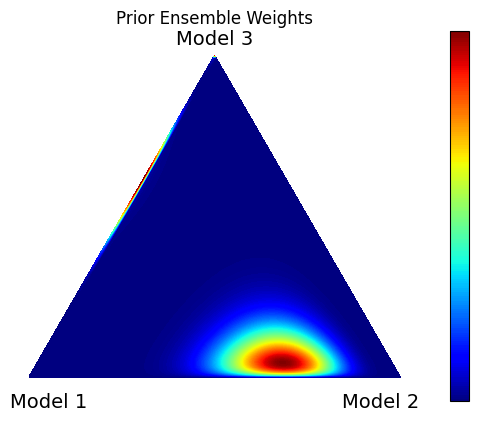

In [ ]:
json_data = plot_weights(ensemble_prior_forecasts["model_weights"], title="Prior Ensemble Weights")


In [ ]:
 
vega.ipy_display(vega.triangle_contour_vega(json_data))

## Calibration

In [ ]:
num_iterations = 100

In [ ]:
import pyro
import dill

save_path = "../../../notebook/april_ensemble/saved_guides/"

try:
    with open(os.path.join(save_path, "inferred_parameters2.pkl"), "rb") as f:
        inferred_parameters = dill.load(f)
    print("Loaded inferred parameters from file.")
except:
    autoguide = pyro.infer.autoguide.AutoDiagonalNormal
    inferred_parameters = calibrate(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=autoguide)

    with open(os.path.join(save_path, "inferred_parameters2.pkl"), "wb") as f:
        dill.dump(inferred_parameters, f)

Loaded inferred parameters from file.


In [ ]:
try:
    with open(os.path.join(save_path, "deterministic_parameters2.pkl"), "rb") as f:
        deterministic_parameters = dill.load(f)
    print("Loaded deterministic parameters from file.")
except: 
    deterministic_autoguide = pyro.infer.autoguide.AutoDelta
    deterministic_parameters = calibrate(ensemble, train_data, num_iterations=num_iterations, verbose=True, verbose_every=10, autoguide=deterministic_autoguide)

    with open(os.path.join(save_path, "deterministic_parameters2.pkl"), "wb") as f:
        dill.dump(deterministic_parameters, f)

Loaded deterministic parameters from file.


In [ ]:
ensemble_posterior_forecasts = sample(ensemble, all_timepoints, num_samples, inferred_parameters)
ensemble_deterministic_forecasts = sample(ensemble, all_timepoints, 1, deterministic_parameters)

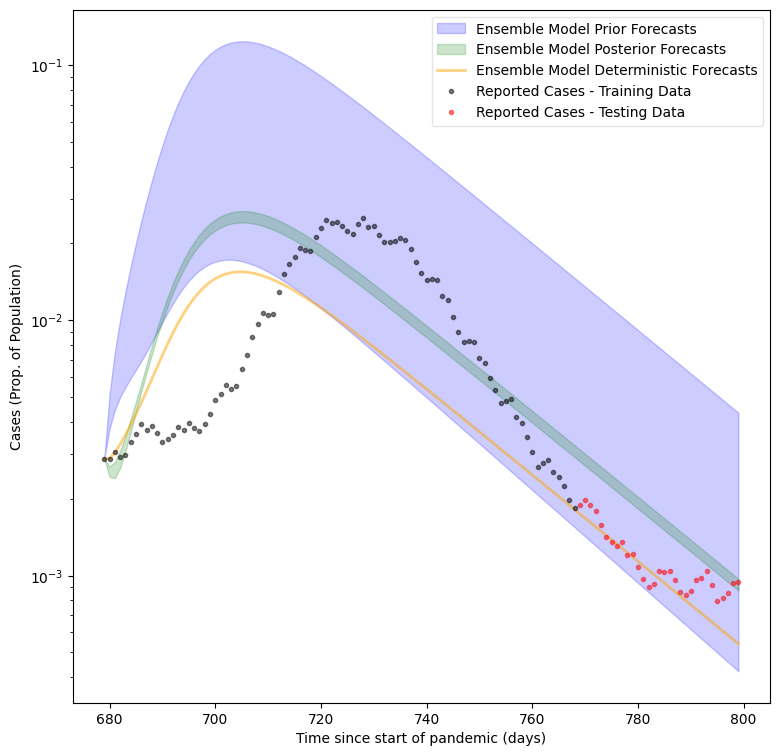

In [ ]:
# Sample from the Ensemble
ax = plot_predictive(ensemble_prior_forecasts, all_timepoints, ax=setup_ax(), color="blue", label="Ensemble Model Prior Forecasts")
ax = plot_predictive(ensemble_posterior_forecasts, all_timepoints, ax=ax, color="green", label="Ensemble Model Posterior Forecasts")
ax = plot_trajectory(ensemble_deterministic_forecasts, all_timepoints, ax=ax, color="orange", label="Ensemble Model Deterministic Forecasts")
ax = plot_observations(train_cases, train_timepoints, ax=ax, color="black", label="Reported Cases - Training Data")
ax = plot_observations(test_cases, test_timepoints, ax=ax, color="red", label="Reported Cases - Testing Data")

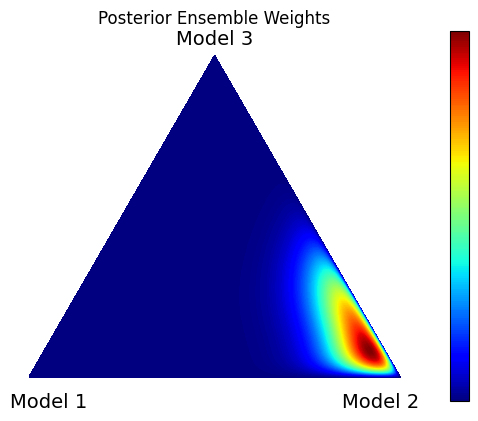

In [ ]:
json_data = plot_weights(ensemble_posterior_forecasts["model_weights"], title="Posterior Ensemble Weights")

In [ ]:
 
vega.ipy_display(vega.triangle_contour_vega(json_data))

## Forecasting over time - Sliding Window Calibration

In [ ]:
dates = pd.date_range(start=train_start_date, end=test_end_date, freq="14D")
dates = [date.strftime("%Y-%m-%d") for date in dates[1:-1]]

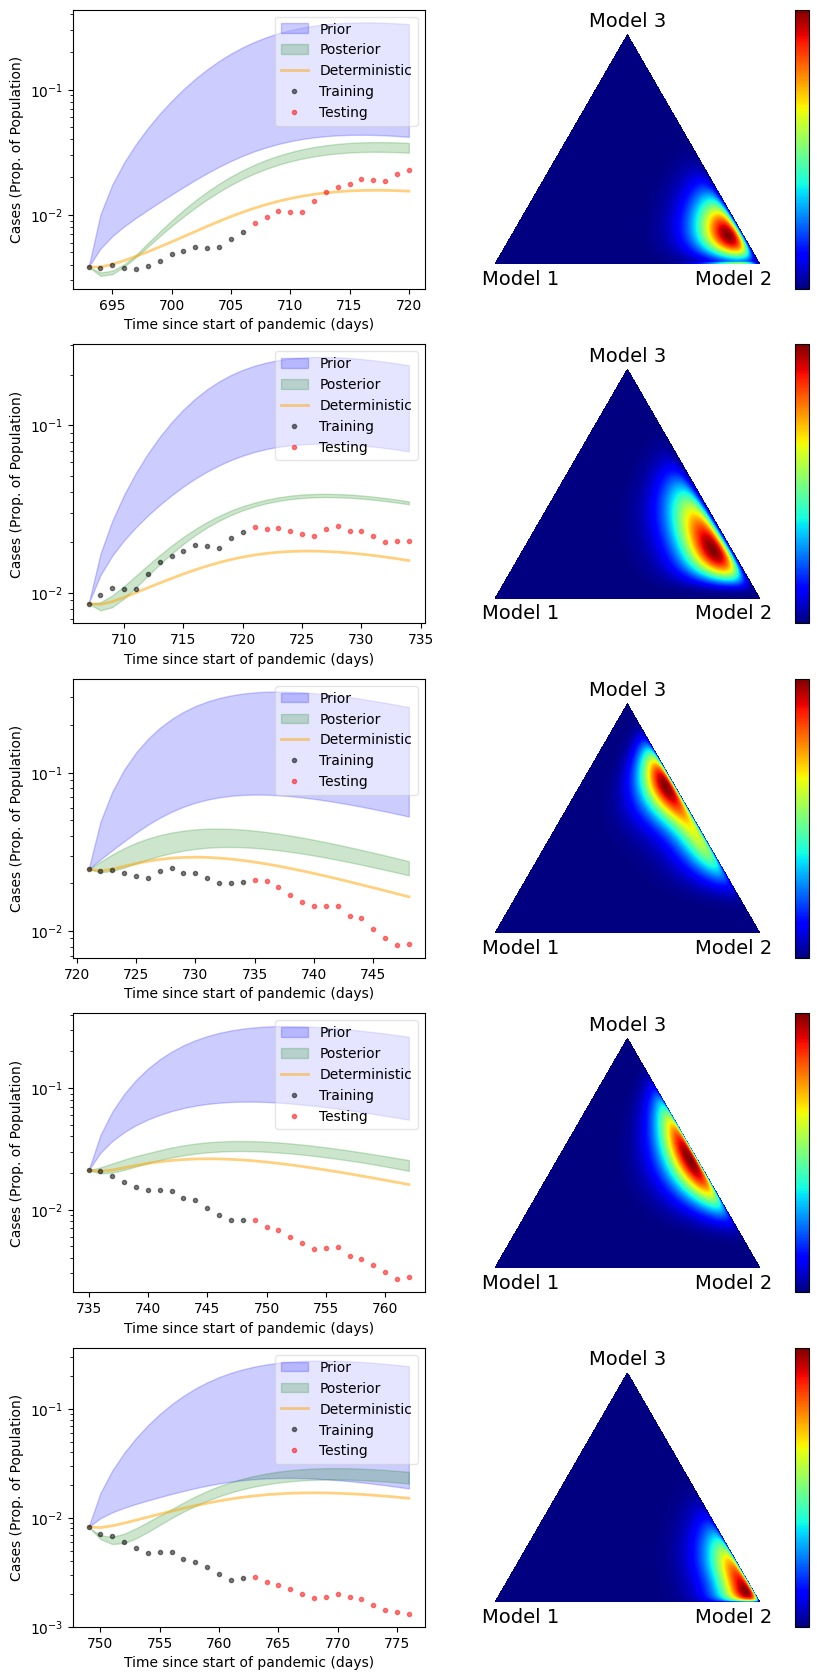

In [ ]:
# Setup plt axes
fig, axes = plt.subplots(nrows=len(dates)-2, ncols=2, figsize=(10, 3*len(dates)))
json_data_list = []
for i in range(1, len(dates)-1):
    _train_start_date = dates[i-1]
    _test_start_date = dates[i]
    _test_end_date = dates[i+1]
    
    _train_data, _train_cases, _train_timepoints, _test_cases, _test_timepoints, _all_timepoints = get_train_test_data(data, _train_start_date, _test_start_date, _test_end_date)
    _start_states = [create_start_state1(data, _train_start_date), create_start_state2(data, _train_start_date), create_start_state3(data, _train_start_date)]
    _start_time = _train_timepoints[0] - 1e-5

    _ensemble = setup_model(models, 
                        weights, 
                        solution_mappings, 
                        _start_time, 
                        _start_states, 
                        ensemble_total_population, 
                        dirichlet_concentration=dirichlet_concentration,
                        noise_pseudocount=noise_pseudocount)
    
    _ensemble_prior_forecasts = sample(_ensemble, _all_timepoints, num_samples)

    try:
        with open(os.path.join(save_path, f"inferred_parameters2_{i}.pkl"), "rb") as f:
            _inferred_parameters = dill.load(f)
    except:
        _autoguide = pyro.infer.autoguide.AutoDiagonalNormal
        _inferred_parameters = calibrate(_ensemble, _train_data, num_iterations=num_iterations, autoguide=_autoguide)

        with open(os.path.join(save_path, f"inferred_parameters2_{i}.pkl"), "wb") as f:
            dill.dump(_inferred_parameters, f)

    _ensemble_posterior_forecasts = sample(_ensemble, _all_timepoints, num_samples, _inferred_parameters)

    try:
        with open(os.path.join(save_path, f"deterministic_parameters2_{i}.pkl"), "rb") as f:
            _deterministic_parameters = dill.load(f)

    except:
        _deterministic_autoguide = pyro.infer.autoguide.AutoDelta
        _deterministic_parameters = calibrate(_ensemble, _train_data, num_iterations=num_iterations, autoguide=_deterministic_autoguide)

        with open(os.path.join(save_path, f"deterministic_parameters2_{i}.pkl"), "wb") as f:
            dill.dump(_deterministic_parameters, f)
    _ensemble_deterministic_forecasts = sample(_ensemble, _all_timepoints, 1, _deterministic_parameters)

    ax = setup_ax(axes[i-1, 0])
    ax = plot_predictive(_ensemble_prior_forecasts, _all_timepoints, ax=ax, color="blue", label="Prior")
    ax = plot_predictive(_ensemble_posterior_forecasts, _all_timepoints, ax=ax, color="green", label="Posterior")
    ax = plot_trajectory(_ensemble_deterministic_forecasts, _all_timepoints, ax=ax, color="orange", label="Deterministic")
    ax = plot_observations(_train_cases, _train_timepoints, ax=ax, color="black", label="Training")
    ax = plot_observations(_test_cases, _test_timepoints, ax=ax, color="red", label="Testing")
    
    json_data = plot_weights(_ensemble_posterior_forecasts["model_weights"], ax=axes[i-1, 1])
    json_data_list.append(json_data)

In [ ]:
for json_data in json_data_list:
    vega.ipy_display(vega.triangle_contour_vega(json_data))